In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import os
from datetime import datetime

## Generating Data

In [3]:
params = {
    'N': 128,
    'M': 20,
    'Tp': 80,
    'Td': 120,
    'Tc': 200
}

In [4]:
def data_generation(params=params, sigma=0.1):
    N = params['N']
    M = params['M']
    Tp = params['Tp']
    Td = params['Td']
    Tc = Tp + Td
    
    possible_values = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / (2**0.5)

    # X -> Data
    X_true = np.empty((M, Tc), dtype=complex) 
    for i in range(Tc):
        x = np.random.choice(possible_values, size=M, p=[0.25, 0.25, 0.25, 0.25])
        X_true[:, i] = x

    X_true = np.array(X_true)

    # H -> Channel
    H_real = np.random.normal(0, 1, (N, M)) / np.sqrt(2)
    H_imag = np.random.normal(0, 1, (N, M)) / np.sqrt(2)
    H = H_real + 1j * H_imag


    # H = H / np.linalg.norm(H)

    # noise -> Noise
    noise = np.random.normal(0, sigma, (N, Tc)) + 1j * np.random.normal(0, sigma, (N, Tc))

    # Y -> Received Signal
    R = H @ X_true + noise/(2**0.5)
    Y = np.sign(np.real(R))  +1j * np.sign(np.imag(R))


    data_known = {
        'N': N,
        'M': M,
        'Tp': Tp,
        'Td': Td,   
        'Tc': Tc,
        'X': X_true[:, :Tp],
        'Y': Y
    }
    data_unknown = {
        'X_true_td': X_true[:, Tp:],
        'H': H,
    }

    return data_known, data_unknown




## Channel Estimation

In [5]:
def channel_estimation(data_known):
    N = data_known['N']
    M = data_known['M']
    
    X_tp = data_known['X']
    Y_tp = data_known['Y'][:, :len(X_tp[0])]

    # Data preparation
    X_tp_tilde = np.concatenate([
        np.concatenate((np.real(X_tp), np.imag(X_tp)), axis=1),
        np.concatenate((-1*np.imag(X_tp), np.real(X_tp)), axis=1)
    ])

    Y_tp_tilde = np.concatenate((np.real(Y_tp), np.imag(Y_tp)), axis=1)
    
    # Channel estimation
    H_hat = np.zeros((N, 2*M))

    X_matrix = X_tp_tilde.transpose()
    for row in range(N):
        y_row = Y_tp_tilde[row]

        C = 1  # Penalty parameter
        clf = SVC(kernel='linear', C=C)
        clf.fit(X_matrix, y_row)

        # Get the hyperplane parameters
        w = clf.coef_[0]
        b = clf.intercept_[0]

        H_hat[row] = (M**0.5) * (w / np.linalg.norm(w))

    H_hat_complex = H_hat[:, :M] + 1j * H_hat[:, M:]
    norm_H_hat = np.linalg.norm(H_hat_complex)
    # H_hat_complex = (H_hat_complex / norm_H_hat) * data_known['H_norm']
    
    return H_hat_complex



In [6]:
def plot_H_hat(H_hat_complex, data_unknown):
    H = data_unknown['H']

    plt.figure(figsize=(10, 4))

    # Plotting the real parts
    plt.subplot(1, 2, 1)
    plt.title('Real Part Comparison')
    plt.scatter(range(len(np.real(H[0]))), np.real(H[0]), label='H[0]', alpha=0.7)
    plt.plot(range(len(np.real(H[0]))), np.real(H[0]), alpha=0.5)  # Line for H[0]
    plt.scatter(range(len(np.real(H_hat_complex[0]))), np.real(H_hat_complex[0]), label='H_hat_complex[0]', alpha=0.7)
    plt.plot(range(len(np.real(H_hat_complex[0]))), np.real(H_hat_complex[0]), alpha=0.5)  # Line for H_hat_complex[0]
    plt.xlabel('Index')
    plt.ylabel('Real Value')
    plt.legend()

    # Plotting the imaginary parts
    plt.subplot(1, 2, 2)
    plt.title('Imaginary Part Comparison')
    plt.scatter(range(len(np.imag(H[0]))), np.imag(H[0]), label='H[0]', alpha=0.7)
    plt.plot(range(len(np.imag(H[0]))), np.imag(H[0]), alpha=0.5)  # Line for H[0]
    plt.scatter(range(len(np.imag(H_hat_complex[0]))), np.imag(H_hat_complex[0]), label='H_hat_complex[0]', alpha=0.7)
    plt.plot(range(len(np.imag(H_hat_complex[0]))), np.imag(H_hat_complex[0]), alpha=0.5)  # Line for H_hat_complex[0]
    plt.xlabel('Index')
    plt.ylabel('Imaginary Value')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Data Detection


In [7]:
def data_detection(data_known, H):
    N = data_known['N']
    M = data_known['M']
    Td = data_known['Td']

    # Data preperation
    Y_td = data_known['Y'][:, -Td:]
    Y_td_tilde = np.concatenate((np.real(Y_td), np.imag(Y_td)))

    H_tilde = np.concatenate([
        np.concatenate((np.real(H), -1*np.imag(H)), axis=1),
        np.concatenate((np.imag(H), np.real(H)), axis=1)
    ])

    # Data detection
    X_hat = np.zeros((Td, 2*M))
    for row in range(Td):
        y_row = Y_td_tilde.transpose()[row]

        C = 1  # Penalty parameter
        clf = SVC(kernel='linear', C=C)
        clf.fit(H_tilde, y_row)

        # Get the hyperplane parameters
        w = clf.coef_[0]
        b = clf.intercept_[0]

        X_hat[row] = (M**0.5) * (w / np.linalg.norm(w))

    X_hat = X_hat.transpose()
    X_hat_complex = X_hat[:M] + 1j * X_hat[M:]

    return X_hat_complex

        

In [8]:
def plot_X_hat(X_hat_complex, data_unknown):
    Td = len(X_hat_complex[0])
    X_true = data_unknown['X_true_td']

    fig = plt.figure(figsize=(16, 5))

    # Plotting the real parts
    plt.subplot(2, 1, 1)
    plt.title('Real Part Comparison')
    plt.scatter(range(len(np.real(X_true[:, -Td:][0]))), np.real(X_true[:, -Td:][0]), label='X_true[:, -Td:][0]', alpha=0.7, s=10)
    plt.scatter(range(len(np.real(X_hat_complex[0]))), np.real(X_hat_complex[0]), label='X_hat_complex[0]', alpha=0.7, s=10)
    plt.xlabel('Index')
    plt.ylabel('Real Value')

    # Plotting the imaginary parts
    plt.subplot(2, 1, 2)
    plt.title('Imaginary Part Comparison')
    plt.scatter(range(len(np.imag(X_true[:, -Td:][0]))), np.imag(X_true[:, -Td:][0]), alpha=0.7, s=10)
    plt.scatter(range(len(np.imag(X_hat_complex[0]))), np.imag(X_hat_complex[0]), alpha=0.7, s=10)
    plt.xlabel('Index')
    plt.ylabel('Imaginary Value')

    # Add common legend at the top
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
    
    plt.tight_layout()
    plt.show()

In [9]:
def get_H_error(H_hat_complex, data_unknown):
    H = data_unknown['H']
    H_error = np.linalg.norm(H - H_hat_complex) / np.linalg.norm(H)
    return H_error

In [10]:
def map_to_quadrant(z):
    real_part = np.real(z)
    imag_part = np.imag(z)
    
    mapped_real = np.where(real_part >= 0, 1, -1)
    mapped_imag = np.where(imag_part >= 0, 1, -1)
    
    return mapped_real + 1j * mapped_imag

In [11]:
def get_nmse(X_hat_complex, data_unknown):
    X_true = data_unknown['X_true_td']
    
    nmse = np.linalg.norm(X_true - X_hat_complex)**2 / np.linalg.norm(X_true)**2
    nmse_db = 10 * np.log10(nmse)
    return nmse_db

In [12]:
def get_ber(X_hat_complex, data_unknown):
    X_true_td = data_unknown['X_true_td']
    X_hat_complex_mapped = map_to_quadrant(X_hat_complex)/(2**0.5)

    total = len(X_true_td.flatten())

    ber = np.sum(X_true_td != X_hat_complex_mapped)/total

    return ber


    


## Single Example

In [13]:
sigma = 0.1
data_known, data_unknown = data_generation(params=params, sigma=sigma)
H_hat_complex = channel_estimation(data_known)

H_error = get_H_error(H_hat_complex, data_unknown)
H_error

np.float64(0.3684745046228417)

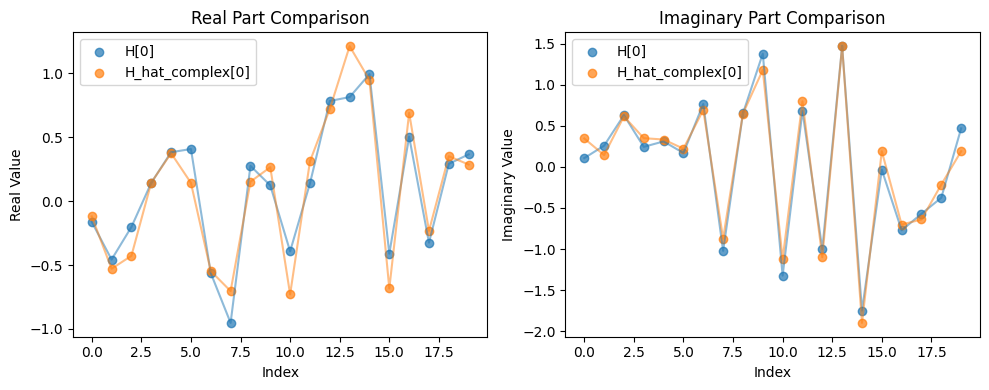

In [14]:
plot_H_hat(H_hat_complex, data_unknown)

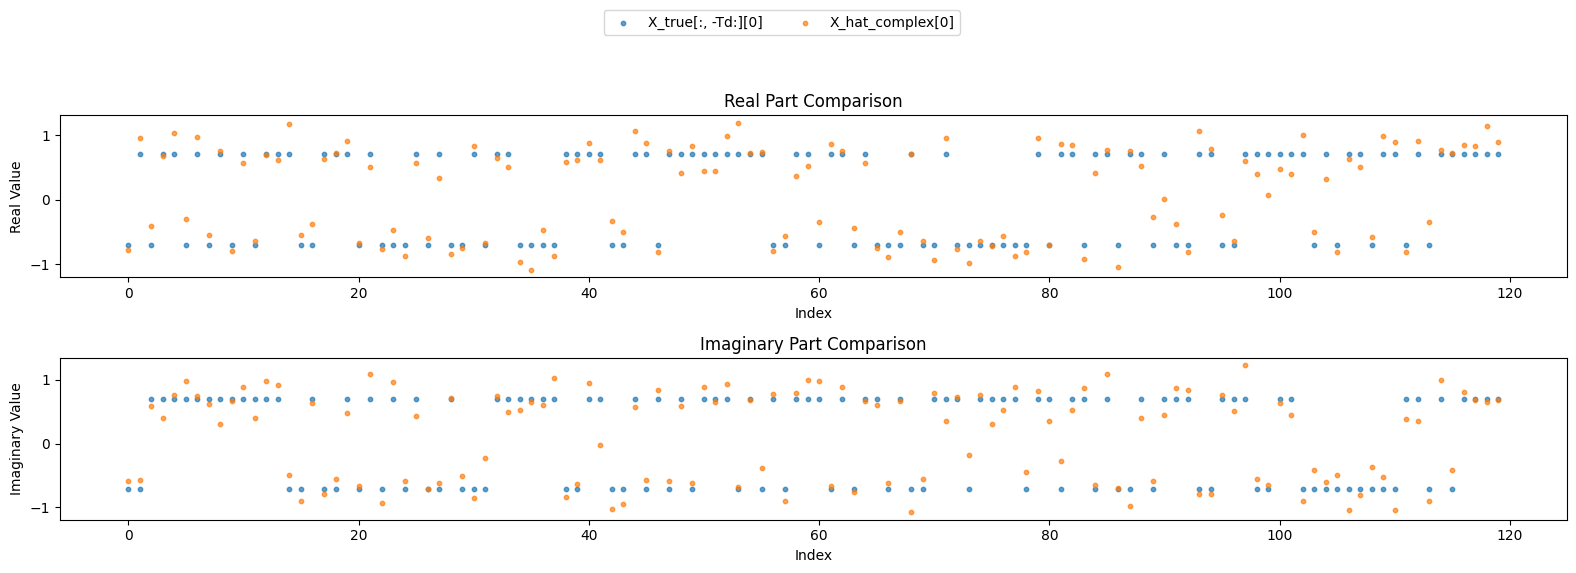

In [15]:
X_hat_complex = data_detection(data_known, H_hat_complex)
plot_X_hat(X_hat_complex, data_unknown)

In [16]:
nmse = get_nmse(X_hat_complex, data_unknown)
ber = get_ber(X_hat_complex, data_unknown)

nmse, ber

(np.float64(-8.917373644821854), np.float64(0.0075))

## Iterative Optimization

In [73]:
sigma = 0.01
data_known, data_unknown = data_generation(params=params, sigma=sigma)

X_tp = data_known['X']
H_last = data_unknown['H']*0
for i in range(30):
    H_hat_complex = channel_estimation(data_known)
    X_hat_complex = data_detection(data_known, H_hat_complex)

    data_known['X'] = np.concatenate((X_tp, X_hat_complex), axis=1)

    nmse = get_nmse(X_hat_complex, data_unknown)
    ber = get_ber(X_hat_complex, data_unknown)
    H_error = get_H_error(H_hat_complex, data_unknown)
        
    if np.linalg.norm(H_last - H_hat_complex)/np.linalg.norm(H_hat_complex) < 3e-2:
        break

    H_last = H_hat_complex

    print(f'H_error: {H_error}, nmse: {nmse}, ber: {ber}')

H_error: 0.3621195544215814, nmse: -8.772822137196654, ber: 0.013333333333333334
H_error: 0.266613500241724, nmse: -9.973658821866902, ber: 0.0033333333333333335
H_error: 0.2572100141941743, nmse: -10.22251512404527, ber: 0.0020833333333333333
H_error: 0.2545264049676795, nmse: -10.25538434329993, ber: 0.0025
H_error: 0.2538277449974441, nmse: -10.298256036352054, ber: 0.0020833333333333333
H_error: 0.25367473214230823, nmse: -10.28918043490217, ber: 0.0025
H_error: 0.2528032042727256, nmse: -10.332750438865494, ber: 0.0020833333333333333


## Multiple Iterations

In [81]:
snr_ranges = list(range(-15,31,5))

# snr = -10log(sigma**2)
# sigma_sq = 10**(-snr/10)

sigma_list = []

for snr in snr_ranges:
    sigma_sq = 10**(-snr/10)
    sigma = sigma_sq**0.5
    sigma_list.append(sigma)

sigma_list

[5.623413251903491,
 3.1622776601683795,
 1.7782794100389228,
 1.0,
 0.5623413251903491,
 0.31622776601683794,
 0.17782794100389226,
 0.1,
 0.05623413251903491,
 0.03162277660168379]

In [82]:
def get_plot_values(params, sigma):    
    data_known, data_unknown = data_generation(params=params, sigma=sigma)
    X_tp = data_known['X']

    H_last = data_unknown['H']*0
    for i in range(10):
        H_hat_complex = channel_estimation(data_known)
        X_hat_complex = data_detection(data_known, H_hat_complex)

        data_known['X'] = np.concatenate((X_tp, X_hat_complex), axis=1)

        nmse = get_nmse(X_hat_complex, data_unknown)
        ber = get_ber(X_hat_complex, data_unknown)
        H_error = get_H_error(H_hat_complex, data_unknown)

        if np.linalg.norm(H_last - H_hat_complex)/np.linalg.norm(H_hat_complex) < 3e-2:
            break
    print(f'H_error: {H_error}, nmse: {nmse}, ber: {ber}')
        
    return H_error, nmse, ber

In [83]:
def create_snr_files():
    """Create CSV files for each SNR value if they don't exist"""
    os.makedirs('data', exist_ok=True)
    
    # Define base columns
    columns = ['timestamp', 'snr', 'sigma', 'nmse', 'ber']
    # Create a file for each SNR if it doesn't exist
    for snr in snr_ranges:
        file_path = f'data/results_snr_{snr}dB.csv'
        if not os.path.exists(file_path):
            df = pd.DataFrame(columns=columns)
            df.to_csv(file_path, index=False)
            print(f"Created file: {file_path}")

create_snr_files()

In [ ]:
NMSE_dict = {}
BER_dict = {}
for sigma_i in range(0, len(snr_ranges)):
    K = 100  # No. of iterations
    NMSE_list = []
    BER_list = []
    for iter in range(K):
        H_error, NMSE, BER = get_plot_values(params, sigma_list[sigma_i])
        NMSE_list.append(NMSE)
        BER_list.append(BER)

        file_path = f'data/results_snr_{snr_ranges[sigma_i]}dB.csv'

        new_row = {
            'timestamp': datetime.now(),
            'snr': snr_ranges[sigma_i],
            'sigma': sigma_list[sigma_i],
            'nmse': NMSE,
            'ber': BER,
        }

        # Check if the file exists, if not create it with headers
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            df = pd.DataFrame(columns=new_row.keys())

        # Append new row and save
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
        df.to_csv(file_path, index=False)

    NMSE_dict[snr_ranges[sigma_i]] = NMSE_list
    BER_dict[snr_ranges[sigma_i]] = BER_list

H_error: 0.6798535826468808, nmse: -1.5519566804256972, ber: 0.36083333333333334
H_error: 0.6998535865554808, nmse: -1.5599352949898049, ber: 0.35791666666666666
H_error: 0.7010609250535443, nmse: -1.5814598852142514, ber: 0.3570833333333333
H_error: 0.6891534820095524, nmse: -1.6153330447673973, ber: 0.35
H_error: 0.7072229784420713, nmse: -1.534192894771556, ber: 0.35208333333333336
H_error: 0.6959133147404059, nmse: -1.5751477226953505, ber: 0.3575
H_error: 0.709346490550781, nmse: -1.5060217092656558, ber: 0.3575
H_error: 0.7148776202644402, nmse: -1.3150609397986708, ber: 0.3804166666666667
H_error: 0.6886680240649679, nmse: -1.596341728781231, ber: 0.34541666666666665
H_error: 0.705503119333875, nmse: -1.6071992823320818, ber: 0.35375
H_error: 0.7142296327468253, nmse: -1.648902489747504, ber: 0.34125
H_error: 0.691935223970701, nmse: -1.572972683076872, ber: 0.35791666666666666
H_error: 0.6978113767699621, nmse: -1.5116941975513614, ber: 0.355
H_error: 0.7073900116929559, nmse: 

In [22]:
BER_dict

{-15: [np.float64(0.3491666666666667)],
 -10: [np.float64(0.12583333333333332)],
 -5: [np.float64(0.0375)],
 0: [np.float64(0.010416666666666666)],
 5: [np.float64(0.0008333333333333334)],
 10: [np.float64(0.002916666666666667)],
 15: [np.float64(0.0020833333333333333)],
 20: [np.float64(0.0025)],
 25: [np.float64(0.0016666666666666668)],
 30: [np.float64(0.0008333333333333334)]}

In [23]:
NMSE_mean_dict = {}
BER_mean_dict = {}
NMSE_std_dict = {}

for key in NMSE_dict.keys():
    NMSE_mean_dict[key] = np.mean(NMSE_dict[key])
    NMSE_std_dict[key] = np.std(NMSE_dict[key])
    BER_mean_dict[key] = np.mean(BER_dict[key])


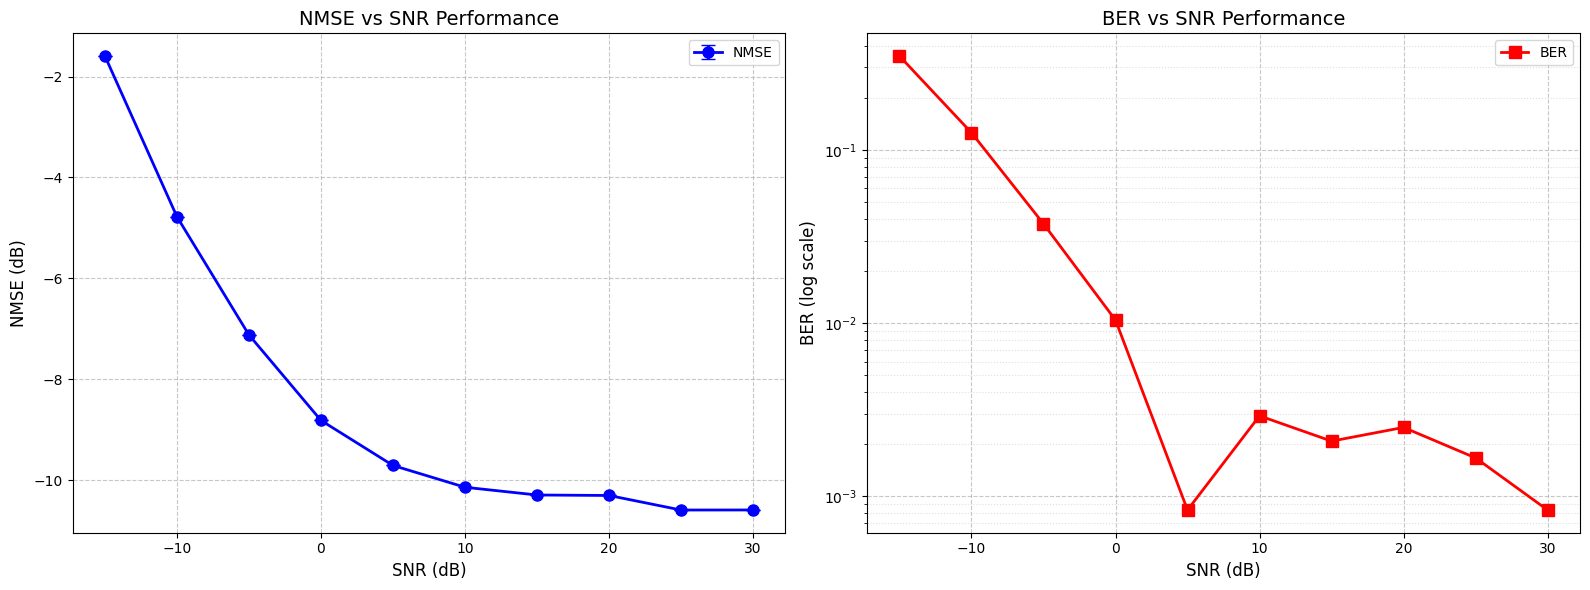

In [ ]:
# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

snr = snr_ranges
nmse = list(NMSE_mean_dict.values())
nmse_std = list(NMSE_std_dict.values())
ber = list(BER_mean_dict.values())

# Plot NMSE with std dev error bars
ax1.errorbar(snr, nmse, 
             yerr=nmse_std,
             marker='o', linestyle='-', linewidth=2, markersize=8,
             color='blue', label='NMSE', capsize=5)
ax1.set_xlabel('SNR (dB)', fontsize=12)
ax1.set_ylabel('NMSE (dB)', fontsize=12)
ax1.set_title('NMSE vs SNR Performance', fontsize=14)
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', alpha=0.4)
ax1.legend()

# Plot BER without error bars
ax2.semilogy(snr, ber,  # Changed to semilogy for logarithmic y-axis
         marker='s', linestyle='-', linewidth=2, markersize=8,
         color='red', label='BER')
ax2.set_xlabel('SNR (dB)', fontsize=12)
ax2.set_ylabel('BER (log scale)', fontsize=12)  # Updated label to indicate log scale
ax2.set_title('BER vs SNR Performance', fontsize=14)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.grid(True, which='minor', linestyle=':', alpha=0.4)
ax2.legend()

plt.tight_layout()
plt.show()

## Visualising Results

In [ ]:
NMSE_dict = {}
BER_dict = {}
for abc in range(1000):
    for sigma_i in range(0, len(snr_ranges)):
        K = 25  # No. of iterations
        NMSE_list = []
        BER_list = []
        for iter in range(K):
            H_error, NMSE, BER = get_plot_values(params, sigma_list[sigma_i])
            NMSE_list.append(NMSE)
            BER_list.append(BER)

            file_path = f'data/results_snr_{snr_ranges[sigma_i]}dB.csv'

            new_row = {
                'timestamp': datetime.now(),
                'snr': snr_ranges[sigma_i],
                'sigma': sigma_list[sigma_i],
                'nmse': NMSE,
                'ber': BER,
            }

            # Check if the file exists, if not create it with headers
            try:
                df = pd.read_csv(file_path)
            except FileNotFoundError:
                df = pd.DataFrame(columns=new_row.keys())

            # Append new row and save
            df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)
            df.to_csv(file_path, index=False)

        NMSE_dict[snr_ranges[sigma_i]] = NMSE_list
        BER_dict[snr_ranges[sigma_i]] = BER_list